## 0. Importing Libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


## 1. Load Data

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainsetwhole = CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
classes = trainsetwhole.classes

class_count = {}
for _, index in trainsetwhole:
    label = classes[index]
    class_count[label] = class_count.get(label, 0) + 1
    
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [25]:
# Generate reduced training and validation sets
train_data_size = int(len(trainsetwhole) * 0.8)
val_data_size = len(trainsetwhole) - train_data_size
train_data, val_data = torch.utils.data.random_split(trainsetwhole,
                                    [train_data_size, val_data_size],
                                    generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

print(f"Size of train: {len(trainloader.sampler)}, Size of val: {len(validloader.sampler)}, " \
       f"Size of test: {len(testloader.sampler)}")

Size of train: 40000, Size of val: 10000, Size of test: 10000


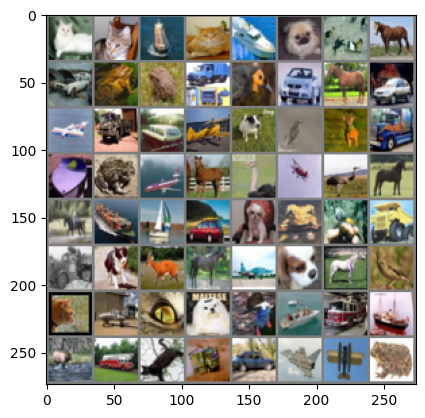

In [29]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#  show graph of train_data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Create Baseline Model

In [31]:
class Net(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc = nn.Linear(in_features=256*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,256*4*4)
        
        output = self.fc(output)
        
        return output
        
net = Net()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device)

criterion = nn.CrossEntropyLoss()    # Loss function is Cross Entropy Loss

optimizer = optim.SGD(net.parameters(), lr=0.001)    # learning rate = 0.001

In [32]:
# Define the Train function for training the model
def Train(net, iterations):

    best_accuracy = 0.0
    train_loss_list = []
    train_accuracy_list = []
    valid_accuracy_list = []


    for iteration in range(iterations):
        
        # Train on training data
        net.train()
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images,labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            optimizer.zero_grad()
            
            outputs = net(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.cpu().data*images.size(0)
            _,prediction = torch.max(outputs.data,1)
            
            train_accuracy += int(torch.sum(prediction==labels.data))
            
        train_accuracy = train_accuracy/40000
        train_loss = train_loss/40000
        
        
        # Evaluate on validation data
        net.eval()
        
        valid_accuracy = 0.0
        
        for i, (images,labels) in enumerate(validloader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            outputs = net(images)
            _,prediction = torch.max(outputs.data,1)
            valid_accuracy += int(torch.sum(prediction==labels.data))
            
        valid_accuracy = valid_accuracy/10000

        # Keep track on the training loss, training accuracy and validation accuracy 
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_accuracy_list.append(valid_accuracy)

    print('Minimum Loss: ', min(train_loss_list).item())
    print('Maximum Training Accuracy: ', max(train_accuracy_list))
    print('Maximum Validation Accuracy: ',max(valid_accuracy_list))

    # plot the graph
    fig, ax = plt.subplots(1,2,figsize=[18,6])
    
    # plot the loss vs iteration
    ax[0].plot([i for i in range(len(train_loss_list))], train_loss_list)
    ax[0].set_title('Training loss vs iteration')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')

    # plot training and validation accuracy vs iteration
    ax[1].plot([i for i in range(len(train_accuracy_list))], train_accuracy_list)
    ax[1].plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list)
    ax[1].set_title('Training and Validation accuracy vs iteration')
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()

